## Evaluating Fairness Issues using Fairness Metrics
Here, and on a synthetic data for AI-based loan approval system, we try to demonstrate how to use the fairness metrics available in Fairlearn package to evaluate the fairness of an ML model.


In [38]:
# Installing the fairlearn package
#!pip install fairlearn

In [39]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score
from fairlearn.metrics import MetricFrame, selection_rate, demographic_parity_difference, equalized_odds_difference
from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio

### Synthetic data
In a real-world loan approval scenario, various features could be used to predict whether or not an individual should be approved for a loan. A sensitive feature like sex could be a source of unfairness in the model's predictions.

In this synthetic example, let's say we have four features that represent an applicant's financial health: credit score, annual income, employment history, and interest rate. We'll use sex as the sensitive attribute. The model is trained to predict loan approval (1 for approval, 0 for denial).

To introduce synthetic bias in our data, we assume females have on average higher interest rates in their previous loans, thus less chance to recive a new one.

Plotting the selection rates across two groups opviusly shows a bias toward male applicants.

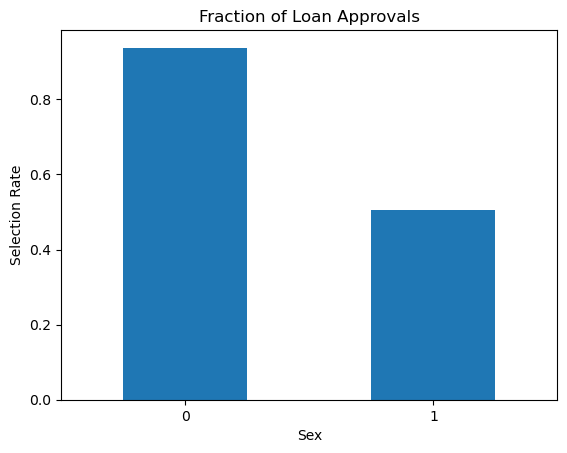

In [40]:
# Generate synthetic data
np.random.seed(42)
n = 1000

# Generate synthetic features:
# - Credit score (normally around 300-850)
# - Annual income in thousands (normally around mean of $50k with std dev of $15k)
# - Employment history in years (normally around 0-40)
X = pd.DataFrame({
    'Credit_Score': np.random.normal(650, 100, n),
    'Annual_Income_k': np.random.normal(50, 15, n),
    'Employment_History_y': np.random.normal(20, 10, n),
    'Interest_Rate': np.random.normal(5, 1, n),
    'Sex': np.random.choice([0, 1], n)  # 0 for 'Male', 1 for 'Female'
})

# Introduce a bias in the 'Interest_Rate' feature based on the sensitive attribute 'Sex'
X.loc[X['Sex'] == 1, 'Interest_Rate'] += 2  # Females have higher interest rates on average

# Introduce a strong bias in the label (loan approval) based on the sensitive attribute (sex)
threshold_male = 1.5  # A relatively low bar for males
threshold_female = 2.0  # A higher bar for females

# Calculate a synthetic loan approval decision based on the financial features and bias

y = pd.DataFrame({'Loan_Approval':np.zeros(X.shape[0])})
y.loc[(X['Sex'] == 0) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_male), 'Loan_Approval'] = 1
y.loc[(X['Sex'] == 1) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_female), 'Loan_Approval'] = 1

selection_rates = MetricFrame(
    metrics=selection_rate, y_true=y['Loan_Approval'], y_pred=y['Loan_Approval'], sensitive_features=X['Sex']
)

fig = selection_rates.by_group.plot.bar(
    legend=False, rot=0, title="Fraction of Loan Approvals", ylabel='Selection Rate'
)

We split the data into training and test set and remove the `Sex` because we know it is a senstive feature and might cause a bias in decision making. But does this solve the our problem? Let's see!

In [41]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 
X_train = X_train.drop(columns=['Sex'])
sensitive_test = X_test['Sex']
X_test = X_test.drop(columns=['Sex'])


We train a random forest classifier and evaluates its performance in terms of balanced accuracy and AUC:

In [42]:
# Train a random forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Measure accuracy
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Measure AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc}")

C:\Users\diego\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8720238095238095
AUC: 0.9546130952380952


Now lets use the tools available in Fairlearn to visualize different fairness-related measures:

''

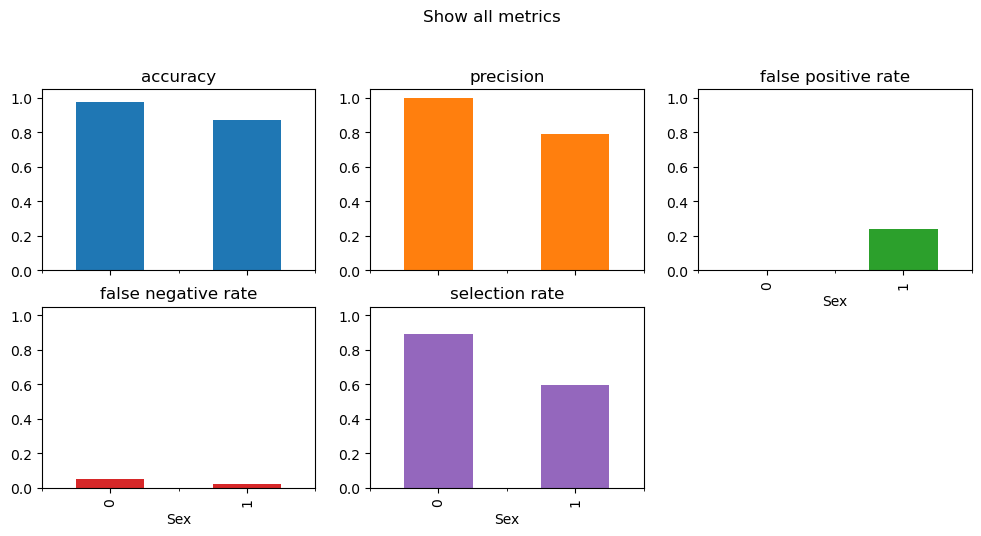

In [43]:
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)
# Analyze metrics using MetricFrame
metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
)
;

Now, lets quantify the fairness metrics:

In [44]:

# Statistical Parity
stat_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity Difference: {stat_parity_diff}")

stat_parity_rto = demographic_parity_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Statistical Parity ratio: {stat_parity_rto}")

# Equalized Odds
equal_odds_diff = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Difference: {equal_odds_diff}")

equal_odds_rto = equalized_odds_ratio(y_test, y_pred, sensitive_features=sensitive_test)
print(f"Equalized Odds Ratio: {equal_odds_rto}")

Statistical Parity Difference: 0.3004807692307693
Statistical Parity ratio: 0.6639784946236559
Equalized Odds Difference: 0.24
Equalized Odds Ratio: 0.0


**Exercise 4.1**: Keep the sex in the training and test data and reevaluate the performance of the model and its fairness metrics. Discuss how and why removing a sensitive feature might affect the perofrmance of the model and its fairness. 

In [45]:
np.random.seed(42)
n = 1000

X = pd.DataFrame({
    'Credit_Score': np.random.normal(650, 100, n),
    'Annual_Income_k': np.random.normal(50, 15, n),
    'Employment_History_y': np.random.normal(20, 10, n),
    'Interest_Rate': np.random.normal(5, 1, n),
    'Sex': np.random.choice([0, 1], n)  # 0 for 'Male', 1 for 'Female'
})

X.loc[X['Sex'] == 1, 'Interest_Rate'] += 2  

threshold_male = 1.5  # A relatively low bar for males
threshold_female = 2.0  # A higher bar for femaless

y = pd.DataFrame({'Loan_Approval':np.zeros(X.shape[0])})
y.loc[(X['Sex'] == 0) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_male), 'Loan_Approval'] = 1
y.loc[(X['Sex'] == 1) & (X['Credit_Score']/650 + X['Annual_Income_k']/50 > threshold_female), 'Loan_Approval'] = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
clf_2 = RandomForestClassifier(random_state=42)
clf_2.fit(X_train, y_train) 
score_sex = clf_2.score(X_test, y_test)
print('Accuracy with sex column: {}'.format(score_sex))


Accuracy with sex column: 0.985


C:\Users\diego\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


''

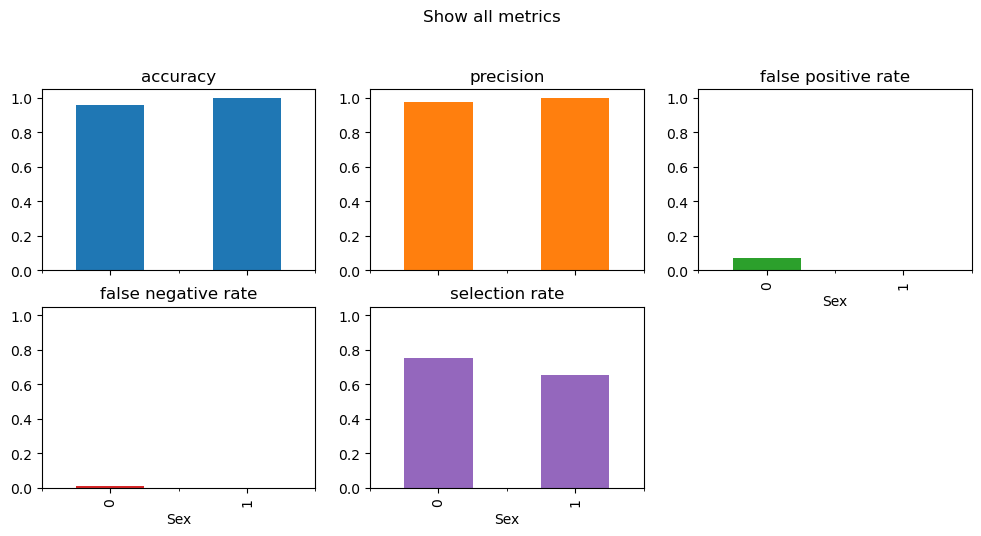

In [47]:
# Analyze metrics using MetricFrame
y_pred = clf_2.predict(X_test) 
sensitive_teste = X_test['Sex'] 

metrics = {
    "accuracy": balanced_accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_test
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    ylim=[0,1.05],
    title="Show all metrics",
) 
;

The removal of sensitive features leads to more trust in the model because when explaining how the outcome may have been different, the invidividuals at hand will not have to deal with explanations that include protected classes that they may belong to. Another impact is that accuracy is decreased if the sensitive feature is simply dropped. The accuracy with the sex column was quite significant, around 0.99. However, this is a synthetic example where the selection of features is oversimplified, so the results here do not necessearily mean that this is what would happen in a real world scenario. Sensitive features can be correlated with other informative features, the issue with including senstive features is that you risk reinforcing the social structures that may be at fault for creating or exacerbating unfair outcomes. The inclusion of sex led to higher false positive rates for males than for females. 